In [1]:
from utils import *
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import random

import warnings
warnings.filterwarnings('ignore')

In [2]:
%store -r data
%store -r target

In [3]:
data = standardize(data)
X_dev, y_dev, X_test, y_test, X_train, y_train, X_val, y_val = split(data,target)

X_train shape: (8091, 51)
X_test shape: (999, 51)
X_val shape: (900, 51)
y_train shape: (8091,)
y_test shape: (999,)
y_val shape: (900,)


### Original Model
Building a model with no parameter tuning and using the raw csv file

In [4]:
model_rf = RandomForestClassifier()
model_rf.fit(X_dev, y_dev)
predsDevrf = model_rf.predict(X_dev)
predsTestrf = model_rf.predict(X_test)

In [5]:
testrf_score =  accuracy_score(y_test, predsTestrf)
devrf_score = accuracy_score(y_dev, predsDevrf)

In [6]:
print("Classification Score for Random Forest on Dev dataset:\n")
print("Dev Score : ", devrf_score)
print(classification_report(y_dev, predsDevrf))
print("--------------------------------------------------------")
print("Classification Score for Random Forest on Test dataset:\n")
print("Test Score :", testrf_score)
print(classification_report(y_test, predsTestrf))

Classification Score for Random Forest on Dev dataset:

Dev Score :  0.9991102213324435
              precision    recall  f1-score   support

       blues       1.00      1.00      1.00       904
   classical       1.00      1.00      1.00       894
     country       1.00      1.00      1.00       886
       disco       1.00      1.00      1.00       890
      hiphop       1.00      1.00      1.00       901
        jazz       1.00      1.00      1.00       886
       metal       1.00      1.00      1.00       923
         pop       1.00      1.00      1.00       896
      reggae       1.00      1.00      1.00       904
        rock       1.00      1.00      1.00       907

    accuracy                           1.00      8991
   macro avg       1.00      1.00      1.00      8991
weighted avg       1.00      1.00      1.00      8991

--------------------------------------------------------
Classification Score for Random Forest on Test dataset:

Test Score : 0.8808808808808809
       

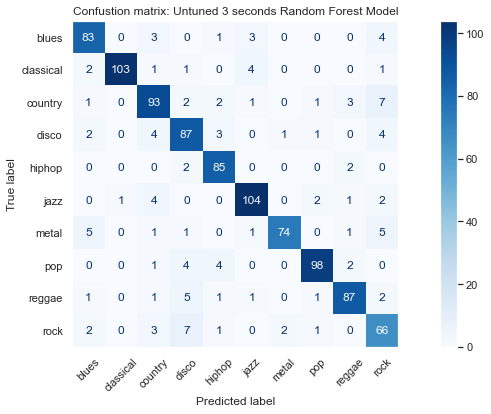

Accuracy : 0.88
Macro F-1 Score : 0.88


In [7]:
# Evaluate Model on Test set
class_labels = list(model_rf.classes_)
macro_f1, accuracy = evaluate_model(predsTestrf, y_test, class_labels, 'Confustion matrix: Untuned 3 seconds Random Forest Model')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the raw csv file

In [8]:

parameters = {'min_samples_split': np.linspace(10,100,5,dtype=int),
              'n_estimators': np.linspace(50,200,5,dtype=int),
             'bootstrap': [True]}

print(parameters)

{'min_samples_split': array([ 10,  32,  55,  77, 100]), 'n_estimators': array([ 50,  87, 125, 162, 200]), 'bootstrap': [True]}


In [9]:
tune_rf = GridSearchCV(estimator = model_rf, param_grid = parameters, cv = 5)
tune_rf.fit(X_dev, y_dev)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True],
                         'min_samples_split': array([ 10,  32,  55,  77, 100]),
                         'n_estimators': array([ 50,  87, 125, 162, 200])})

In [10]:
print("Best Score :", tune_rf.best_score_)
print("Best Parameters :",tune_rf.best_params_)

Best Score : 0.8504056449603382
Best Parameters : {'bootstrap': True, 'min_samples_split': 10, 'n_estimators': 200}


In [11]:
predsDevrf_tuned = tune_rf.predict(X_dev)
predsTestrf_tuned = tune_rf.predict(X_test)

print("Score on Dev data for RF using GridSearchCV:", accuracy_score(y_dev, predsDevrf_tuned))
print("Score on Test data for RF using GridSearchCV:",accuracy_score(y_test, predsTestrf_tuned))

Score on Dev data for RF using GridSearchCV: 0.9976643309976644
Score on Test data for RF using GridSearchCV: 0.8628628628628628


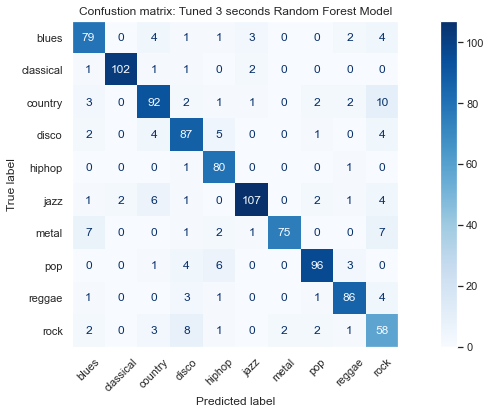

Accuracy : 0.86
Macro F-1 Score : 0.86


In [12]:
# Evaluate Model on Test set
class_labels = list(tune_rf.classes_)
macro_f1, accuracy = evaluate_model(predsTestrf_tuned, y_test, class_labels, 'Confustion matrix: Tuned 3 seconds Random Forest Model')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

In [13]:
## Plot top 3 Important Features of tuned model

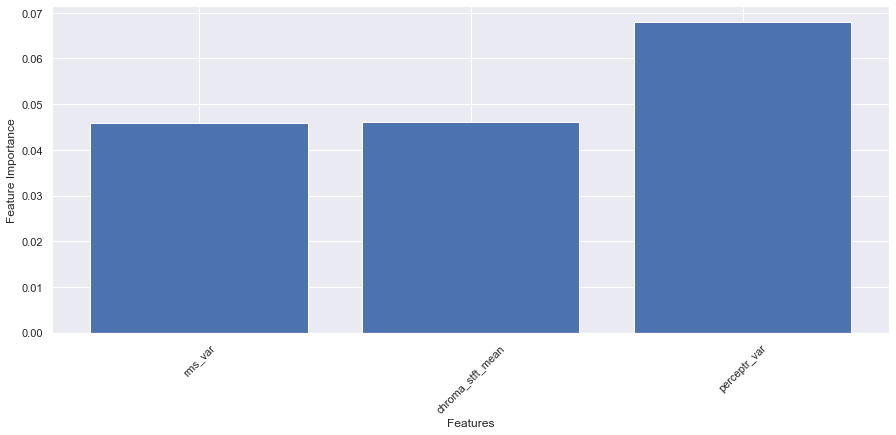

In [14]:
feature_imp_rf = tune_rf.best_estimator_.feature_importances_
final_list_rf = zip(feature_imp_rf,X_dev.columns)
res_rf = sorted(final_list_rf, key = lambda x: x[0])
res_rf = res_rf[-3:]

plt.bar(range(len(res_rf)),[val[0] for val in res_rf],align='center')
plt.xticks(range(len(res_rf)),[val[1] for val in res_rf])
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.show()

### Dimensionality reduction of data using PCA

In [15]:
# Principal Component Analysis 
### cite : https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/

# create the PCA instance
pca = PCA(n_components=30)
# fit on data
pca_data = pca.fit_transform(X_dev)
pca_data_test = pca.transform(X_test)
# pca_data_dev = pca.transform(X_dev)
PCA_df= pd.DataFrame(data=pca_data)
y_dev.index = PCA_df.index
pca_final=pd.concat([PCA_df,y_dev], axis = 1)
# access values
print("Explained Variance of each component:",pca.explained_variance_)
print("Sum of Explained Variance:", sum(pca.explained_variance_ratio_))

Explained Variance of each component: [0.11454404 0.08920634 0.04504717 0.02937379 0.02274578 0.0199205
 0.01584086 0.01368273 0.01132293 0.01090893 0.0089262  0.008148
 0.00722979 0.006841   0.00622568 0.00604715 0.00535512 0.00529879
 0.0050826  0.00483065 0.00472009 0.00416841 0.00364294 0.00346888
 0.00329352 0.0030608  0.00283906 0.00281221 0.00273399 0.00269514]
Sum of Explained Variance: 0.9368498885330538


In [16]:
pca_final.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,label
0,-0.262197,-0.041290,-0.004825,0.077376,-0.092647,-0.202191,0.134131,-0.029623,0.065911,0.012882,...,-0.035848,0.006480,-0.061054,-0.057476,-0.023107,0.001994,0.003538,0.002800,-0.036132,blues
1,0.911816,0.656705,0.093061,0.041841,0.162399,-0.345909,-0.111050,0.005575,0.107248,0.058348,...,0.020704,-0.114862,0.038402,0.045489,0.023884,-0.085575,0.056105,0.108482,-0.019526,pop
2,-0.346865,0.190015,-0.015068,-0.042262,0.002092,-0.081456,-0.064498,-0.077146,-0.020676,-0.082207,...,-0.023594,0.041344,0.010361,-0.001408,0.056005,-0.023745,-0.028424,-0.005041,-0.037435,rock
3,0.165602,-0.054123,-0.230414,-0.096289,0.254819,0.184296,-0.224988,0.077990,-0.083900,-0.040340,...,0.058999,0.028223,0.053810,0.004028,-0.013025,0.026808,-0.132885,-0.017258,-0.062360,jazz
4,-0.213596,0.153496,0.162250,0.171556,0.164251,-0.038910,0.033235,0.036490,0.089948,0.132921,...,0.094422,0.053845,0.074526,-0.043419,-0.001144,-0.053636,-0.032664,-0.005038,-0.040211,hiphop


In [17]:
# from sklearn.preprocessing import OrdinalEncoder
# encoder  = OrdinalEncoder()
# encoder.fit(pca_final.iloc[:,10].reshape(-1, 1))
# y_train_encoded = encoder.transform(pca_final.iloc[:,10])

### PCA - Original Model
Building a model with no parameter tuning and using the PCA data

In [18]:
model_pca = model_rf
model_pca.fit(pca_final.iloc[:,:30], pca_final.iloc[:,30])
pcaTrainrf = model_pca.predict(pca_data)
pcaTestrf = model_pca.predict(pca_data_test)

In [19]:
pcatestrf_score =  accuracy_score(y_test, pcaTestrf)
pcarf_score = accuracy_score(y_dev, pcaTrainrf)

In [20]:
print("Classification Score for Random Forest on Train dataset:\n")
print("Train Score : ", pcarf_score)
print("--------------------------------------------------------")
print("Classification Score for Random Forest on Test dataset:\n")
print("Test Score :", pcatestrf_score)

Classification Score for Random Forest on Train dataset:

Train Score :  0.9991102213324435
--------------------------------------------------------
Classification Score for Random Forest on Test dataset:

Test Score : 0.8598598598598599


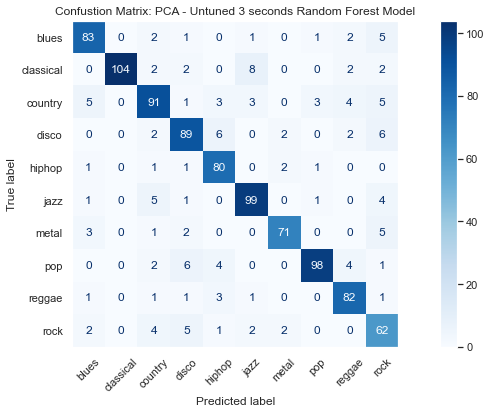

Accuracy : 0.86
Macro F-1 Score : 0.86


In [21]:
# Evaluate Model
class_labels = list(model_rf.classes_)
macro_f1, accuracy = evaluate_model(pcaTestrf, y_test, class_labels, 'Confustion Matrix: PCA - Untuned 3 seconds Random Forest Model')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### PCA - Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the PCA data

In [22]:
pca_final.iloc[:,:30]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.262197,-0.041290,-0.004825,0.077376,-0.092647,-0.202191,0.134131,-0.029623,0.065911,0.012882,...,-0.010885,-0.035848,0.006480,-0.061054,-0.057476,-0.023107,0.001994,0.003538,0.002800,-0.036132
1,0.911816,0.656705,0.093061,0.041841,0.162399,-0.345909,-0.111050,0.005575,0.107248,0.058348,...,0.006422,0.020704,-0.114862,0.038402,0.045489,0.023884,-0.085575,0.056105,0.108482,-0.019526
2,-0.346865,0.190015,-0.015068,-0.042262,0.002092,-0.081456,-0.064498,-0.077146,-0.020676,-0.082207,...,-0.048886,-0.023594,0.041344,0.010361,-0.001408,0.056005,-0.023745,-0.028424,-0.005041,-0.037435
3,0.165602,-0.054123,-0.230414,-0.096289,0.254819,0.184296,-0.224988,0.077990,-0.083900,-0.040340,...,-0.023749,0.058999,0.028223,0.053810,0.004028,-0.013025,0.026808,-0.132885,-0.017258,-0.062360
4,-0.213596,0.153496,0.162250,0.171556,0.164251,-0.038910,0.033235,0.036490,0.089948,0.132921,...,-0.050846,0.094422,0.053845,0.074526,-0.043419,-0.001144,-0.053636,-0.032664,-0.005038,-0.040211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8986,0.223969,0.199646,-0.304657,0.107035,0.128513,-0.077396,0.112850,-0.020112,-0.039325,0.079152,...,-0.061112,0.002657,0.040629,0.021203,0.063145,-0.031071,0.040040,0.029647,0.064600,0.020773
8987,-0.606602,0.172697,-0.153625,0.181308,-0.121463,0.157417,0.025889,0.059124,-0.051088,-0.138443,...,-0.001077,-0.033781,-0.049086,0.008078,-0.007994,-0.022208,-0.017613,-0.051295,-0.022714,0.041045
8988,-0.049191,0.533015,0.390142,-0.164060,0.121950,0.004290,0.132505,-0.029920,0.190388,0.052232,...,0.008877,0.096767,0.103511,-0.006781,0.010058,0.096222,0.005959,-0.103259,-0.064227,0.065514
8989,0.060511,-0.364952,-0.044975,-0.081345,-0.295757,-0.073174,-0.190962,-0.031104,-0.108373,0.086480,...,-0.088487,-0.007599,0.001593,-0.062952,-0.037769,0.153571,0.014003,-0.029304,-0.023847,-0.035796


In [23]:
model_pca_tuned = tune_rf
model_pca_tuned.fit(pca_final.iloc[:,:30], pca_final.iloc[:,30])
pcaTrainrf_tuned = model_pca_tuned.predict(pca_data)
pcaTestrf_tuned = model_pca_tuned.predict(pca_data_test)

In [24]:
pcatestrf_score =  accuracy_score(y_test, pcaTestrf_tuned)
pcarf_score = accuracy_score(y_dev, pcaTrainrf_tuned)

In [25]:
print("Classification Score for Random Forest on Train dataset:\n")
print("Train Score : ", pcarf_score)
print("--------------------------------------------------------")
print("Classification Score for Random Forest on Test dataset:\n")
print("Test Score :", pcatestrf_score)

Classification Score for Random Forest on Train dataset:

Train Score :  0.9977755533311089
--------------------------------------------------------
Classification Score for Random Forest on Test dataset:

Test Score : 0.8318318318318318


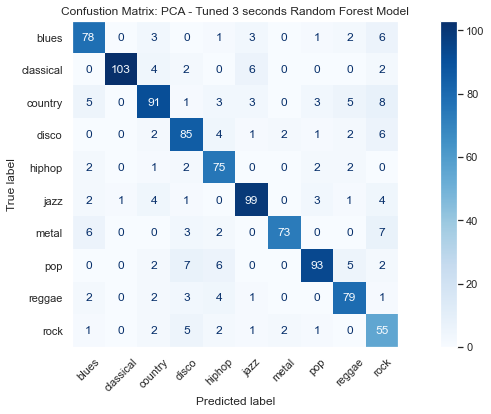

Accuracy : 0.83
Macro F-1 Score : 0.83


In [27]:
# Evaluate Model
class_labels = list(model_rf.classes_)
macro_f1, accuracy = evaluate_model(pcaTestrf_tuned, y_test, class_labels, 'Confustion Matrix: PCA - Tuned 3 seconds Random Forest Model')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)